In [1]:
import pandas as pd, numpy as np, holidays, seaborn as sns, matplotlib.pyplot as plt, time, xgboost as xgb
from sqlalchemy import create_engine
from datetime import datetime
from matplotlib import pyplot

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from config import config

<h1>Modelling Feature Selection and Model Tuning</h1>
<br>
<div>This workbook goes through the process of creating a DataFrame combining leavetimes, trips, and weather info from the DB, cleaning the features, selecting features that are fit for predictive modelling and tuning the model parameters for the identified modelling techniques for the bus route '15A', direction 1. We chose this route because we expect it to be one of the most challenging routes to create predictions for as the setup of two linear regressors in our prototype failed to make good sensible predictions for it.</div>

In [2]:
config=config()
engine=create_engine("postgresql://"+config["user"]+":"+config["password"]+"@"+config["host"]+"/"+config["database"])

In [3]:
line='15A'
direction=1
sql=("SELECT lt.daystamp, lt.progr_number, lt.stoppoint_id,lt.arrival_time_p,lt.arrival_time_a,"
    "lt.departure_time_p,lt.departure_time_a,trips.route_id,"
     "trips.arrival_time_p,trips.departure_time_p,trips.departure_time_a,"
     "weather_main,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_description "
     "FROM leavetimes AS lt, trips, weather "
     "WHERE trips.line_id='"+line+"' AND trips.direction="+str(direction)+" AND trips.suppressed=0 "
     "AND lt.daystamp = trips.daystamp AND lt.trip_id = trips.trip_id AND lt.suppressed=0"
     "AND lt.weather_id = weather.daytime")

In [4]:
df = pd.read_sql(sql,engine)

In [5]:
df.shape

(614114, 22)

In [6]:
df.head()

,daystamp,progr_number,stoppoint_id,arrival_time_p,arrival_time_a,departure_time_p,departure_time_a,route_id,arrival_time_p,departure_time_p,...,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_description
0,1518912000,1,395,57600,57655,57600,57655,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
1,1518912000,2,396,57662,57697,57662,57716,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
2,1518912000,3,397,57696,57820,57696,57837,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
3,1518912000,4,398,57746,57865,57746,57865,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
4,1518912000,5,399,57787,57887,57787,57914,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain


In [7]:
features=list(df.columns)
features

['daystamp',
 'progr_number',
 'stoppoint_id',
 'arrival_time_p',
 'arrival_time_a',
 'departure_time_p',
 'departure_time_a',
 'route_id',
 'arrival_time_p',
 'departure_time_p',
 'departure_time_a',
 'weather_main',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'clouds_all',
 'weather_description']

In [8]:
features[0]="daystamp"
features[2]="stop_id"
features[3]="arr_p"
features[4]="arr_a"
features[5]="dep_p"
features[6]="dep_a"
features[8]="end_p"
features[9]="start_p"
features[10]="start_a"

In [9]:
df.columns=features

In [10]:
df.head()

,daystamp,progr_number,stop_id,arr_p,arr_a,dep_p,dep_a,route_id,end_p,start_p,...,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_description
0,1518912000,1,395,57600,57655,57600,57655,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
1,1518912000,2,396,57662,57697,57662,57716,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
2,1518912000,3,397,57696,57820,57696,57837,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
3,1518912000,4,398,57746,57865,57746,57865,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain
4,1518912000,5,399,57787,57887,57787,57914,83,59806,57600,...,9.76,5.5,8.43,10.0,1016,93,5.66,240,75,light intensity drizzle rain


In [11]:
def daystamp_converter(time):
    date=datetime.fromtimestamp(time)
    holidays_IE=holidays.Ireland()
    if date in holidays_IE:
        holiday=1
    else:
        holiday=0
    return (date.weekday(),date.month,date.hour,holiday)

In [12]:
df["dt"]=df.daystamp.values+df.dep_p.values

In [13]:
df["weekday"],df["month"],df["hour"],df["holiday"]=zip(*df['dt'].apply(daystamp_converter))

In [14]:
df.head()

,daystamp,progr_number,stop_id,arr_p,arr_a,dep_p,dep_a,route_id,end_p,start_p,...,humidity,wind_speed,wind_deg,clouds_all,weather_description,dt,weekday,month,hour,holiday
0,1518912000,1,395,57600,57655,57600,57655,83,59806,57600,...,93,5.66,240,75,light intensity drizzle rain,1518969600,6,2,16,0
1,1518912000,2,396,57662,57697,57662,57716,83,59806,57600,...,93,5.66,240,75,light intensity drizzle rain,1518969662,6,2,16,0
2,1518912000,3,397,57696,57820,57696,57837,83,59806,57600,...,93,5.66,240,75,light intensity drizzle rain,1518969696,6,2,16,0
3,1518912000,4,398,57746,57865,57746,57865,83,59806,57600,...,93,5.66,240,75,light intensity drizzle rain,1518969746,6,2,16,0
4,1518912000,5,399,57787,57887,57787,57914,83,59806,57600,...,93,5.66,240,75,light intensity drizzle rain,1518969787,6,2,16,0


In [15]:
df["dur_s"]=df.dep_p.values-df.start_p.values
df["dur_a"]=df.dep_a.values-df.start_a.values

<h3>Feature Cleaning</h3>

Filter out unusual routes:

In [16]:
route_counts=df.route_id.value_counts()
indices=route_counts.index
values=route_counts.values
cum_value=0
size=df.shape[0]
index=1
for value in values:
    cum_value+=value
    ratio=cum_value/size
    print(f"{index} most common route(s) cover {ratio*100:.2f}% of the routes.")
    if(ratio>0.8):
        break
    index+=1

1 most common route(s) cover 100.00% of the routes.


In [17]:
routes=indices[:index]
routes

Int64Index([83], dtype='int64')

In [18]:
df_clean=df[df.route_id.isin(routes)]

In [19]:
df_clean.shape

(614114, 29)

Check for null values

In [20]:
df_clean.isnull().sum()

daystamp                   0
progr_number               0
stop_id                    0
arr_p                      0
arr_a                      0
dep_p                      0
dep_a                      0
route_id                   0
end_p                      0
start_p                    0
start_a                17943
weather_main               0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
humidity                   0
wind_speed                 0
wind_deg                   0
clouds_all                 0
weather_description        0
dt                         0
weekday                    0
month                      0
hour                       0
holiday                    0
dur_s                      0
dur_a                  17943
dtype: int64

In [21]:
df_clean.isnull().sum().sum()/df_clean.shape[0]

0.058435404501444355

In [22]:
df_clean = df_clean.dropna(axis = 0, how ='any') 

See how resulting stops line up:

In [23]:
stop_counts=df_clean.stop_id.value_counts()

In [24]:
stop_counts

395     15405
398     15335
399     15330
1020    15310
1076    15310
1018    15310
1019    15309
1077    15309
1078    15306
1017    15304
1079    15300
1080    15300
1081    15299
1096    15297
1082    15297
1086    15297
1095    15296
1093    15296
1094    15295
1092    15295
1091    15295
1085    15293
1083    15293
1090    15281
396     15280
1016    15278
1089    15275
1088    15275
1087    15274
397     15267
7581    15264
1101    15260
7579    15258
1283    15257
1285    15254
400     15248
1102    15208
1103    15208
1104    15203
Name: stop_id, dtype: int64

In [25]:
min(stop_counts)/max(stop_counts)

0.9868873742291464

examine distribution and cardinality of features

In [26]:
categorical=["stop_id","route_id","weather_main","weather_description","weekday","month","hour","holiday"]
df_clean[categorical]=df_clean[categorical].astype("category")
ints=['daystamp','progr_number','arr_p','arr_a','dep_p','dep_a','dur_s','dur_a','pressure','humidity','wind_deg','clouds_all']
floats=['temp','feels_like','temp_min','temp_max','wind_speed']

In [27]:
df_clean[categorical].describe()

,stop_id,route_id,weather_main,weather_description,weekday,month,hour,holiday
count,596171,596171,596171,596171,596171,596171,596171,596171
unique,39,1,8,20,7,12,20,2
top,395,83,Clouds,broken clouds,1,1,18,0
freq,15405,596171,472762,294019,94266,52557,44109,585959


In [28]:
for feature in categorical:
    print(f"Distribution for feature {feature}:")
    print(df_clean[feature].value_counts())
    print("")

Distribution for feature stop_id:
395     15405
398     15335
399     15330
1076    15310
1018    15310
1020    15310
1019    15309
1077    15309
1078    15306
1017    15304
1080    15300
1079    15300
1081    15299
1082    15297
1086    15297
1096    15297
1093    15296
1095    15296
1091    15295
1092    15295
1094    15295
1085    15293
1083    15293
1090    15281
396     15280
1016    15278
1088    15275
1089    15275
1087    15274
397     15267
7581    15264
1101    15260
7579    15258
1283    15257
1285    15254
400     15248
1102    15208
1103    15208
1104    15203
Name: stop_id, dtype: int64

Distribution for feature route_id:
83    596171
Name: route_id, dtype: int64

Distribution for feature weather_main:
Clouds     472762
Rain        67290
Drizzle     31157
Clear       14156
Fog          3840
Mist         3435
Snow         3409
Smoke         122
Name: weather_main, dtype: int64

Distribution for feature weather_description:
broken clouds                   294019
scattered c

Question here is whether the added granularity from weather_main to weather_description is worth the added cardinality of 12.
Cardinality of 1 for route_id means that it can be dropped safely.

In [29]:
df_clean=df_clean.drop(["route_id"],axis=1)

In [30]:
df_clean[ints]=df_clean[ints].astype('int64')

In [31]:
df_clean[ints].describe()

,daystamp,progr_number,arr_p,arr_a,dep_p,dep_a,dur_s,dur_a,pressure,humidity,wind_deg,clouds_all
count,5.961710e+05,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000,596171.000000
mean,1.530427e+09,19.989379,53522.434813,53767.061392,53522.434813,53779.043325,1386.999846,1540.444844,1012.727028,77.037092,190.340342,60.610234
std,9.056187e+06,11.251731,17602.012182,17608.071716,17602.012182,17611.159007,776.516869,889.372075,11.703424,13.524969,89.130387,23.271634
min,1.514765e+09,1.000000,21600.000000,21374.000000,21600.000000,21374.000000,0.000000,-6885.000000,979.000000,25.000000,0.000000,0.000000
25%,1.522710e+09,10.000000,38338.000000,38523.000000,38338.000000,38531.000000,874.000000,956.000000,1005.000000,68.000000,130.000000,40.000000
50%,1.530400e+09,20.000000,53414.000000,53675.000000,53414.000000,53689.000000,1423.000000,1563.000000,1014.000000,77.000000,210.000000,75.000000
75%,1.538348e+09,30.000000,67413.000000,67822.000000,67413.000000,67839.000000,1941.000000,2141.000000,1021.000000,87.000000,260.000000,75.000000
max,1.546214e+09,39.000000,86918.000000,87654.000000,86918.000000,87654.000000,3826.000000,10373.000000,1041.000000,100.000000,360.000000,100.000000


Negative values for durations need to be inspected closer:

In [32]:
df_clean[df_clean.dur_a<0]

,daystamp,progr_number,stop_id,arr_p,arr_a,dep_p,dep_a,end_p,start_p,start_a,...,wind_deg,clouds_all,weather_description,dt,weekday,month,hour,holiday,dur_s,dur_a
3944,1523314800,2,396,72075,72102,72075,72135,74555,72000,73755.0,...,30,75,light intensity drizzle,1523386875,1,4,20,0,75,-1620
3945,1523314800,3,397,72116,72222,72116,72241,74555,72000,73755.0,...,30,75,light intensity drizzle,1523386916,1,4,20,0,116,-1514
3946,1523314800,4,398,72177,72269,72177,72284,74555,72000,73755.0,...,30,75,light intensity drizzle,1523386977,1,4,20,0,177,-1471
3947,1523314800,5,399,72227,72309,72227,72320,74555,72000,73755.0,...,30,75,light intensity drizzle,1523387027,1,4,20,0,227,-1435
3948,1523314800,6,400,72316,72424,72316,72443,74555,72000,73755.0,...,30,75,light intensity drizzle,1523387116,1,4,20,0,316,-1312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595332,1527116400,4,398,58405,58458,58405,58481,61161,58200,58922.0,...,60,75,light intensity shower rain,1527174805,3,5,16,0,205,-441
595333,1527116400,5,399,58463,58609,58463,58656,61161,58200,58922.0,...,60,75,light intensity shower rain,1527174863,3,5,16,0,263,-266
595334,1527116400,6,400,58567,58723,58567,58755,61161,58200,58922.0,...,60,75,light intensity shower rain,1527174967,3,5,16,0,367,-167
601455,1526943600,2,396,58287,58287,58287,58320,61161,58200,58472.0,...,30,75,broken clouds,1527001887,1,5,16,0,87,-152


In [33]:
print(f"{df_clean[df_clean.dur_a<0].shape[0]/df_clean.shape[0]*100:.2f}% of the remaining data show negative durations.")

0.18% of the remaining data show negative durations.


Number is low enough to justify dropping the negative rows without doing any further investigation

In [34]:
df_clean=df_clean[df_clean.dur_a>=0]

The last data cleaning operation refers to redundancy: As the route_id has a cardinality of 1, the stop_ids and progr_numbers of one dataset (i.e. per route and direction) have a perfectly positive correlation. As stop_id "only" nominal data and progr_number is ordinal (i.e. progr_number 2 comes after 1 for every trip), we will discard stop_id.

In [35]:
df_clean=df_clean.drop(["stop_id"],axis=1)

<h3>Feature Selection</h3>
<br>
<div>Problem domain: Some categorical features, some numeric features, numeric target variable.</div>

For categorical input, chi squared is recommended.
For numerical input, ANOVA f-test ("Analysis of Variance") or Mutual Information Statistics are used:

In [51]:
y=df_clean["dur_a"]
X=df_clean.drop(["dur_a"],axis=1)

In [52]:
X=X.rename(columns={"weather_main":"w_main","weather_description":"w_des"})

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [54]:
categorical=X_train.columns[X_train.dtypes=="category"]

In [55]:
X_train_categorical=X_train[categorical]

In [56]:
X_test_categorical=X_test[categorical]

In [57]:
X_train_enc=pd.get_dummies(X_train_categorical,drop_first=True)
X_test_enc=pd.get_dummies(X_test_categorical,drop_first=True)

In [58]:
dummy_columns=list(X_train_enc.columns)

In [59]:
fs=SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train_enc,y_train)
X_train_fs=fs.transform(X_train_enc)
X_test_fs=fs.transform(X_test_enc)

In [60]:
for i in range(len(fs.scores_)):
    print(f'Feature {dummy_columns[i]}: {fs.scores_[i]}')

Feature w_main_Clouds: 0.5210818127383798
Feature w_main_Drizzle: 150.34876973231607
Feature w_main_Fog: 26.676339896968717
Feature w_main_Mist: 8.315431665979071
Feature w_main_Rain: 158.7915872436106
Feature w_main_Smoke: 0.6450915418705884
Feature w_main_Snow: 17.290002430275297
Feature w_des_broken clouds: 3.553352744630799
Feature w_des_drizzle: 19.438926176398475
Feature w_des_few clouds: 22.036682700395176
Feature w_des_fog: 26.676339896968717
Feature w_des_heavy intensity rain: 36.594682418244226
Feature w_des_light intensity drizzle: 27.541571618415517
Feature w_des_light intensity drizzle rain: 164.2594514926708
Feature w_des_light intensity shower rain: 41.47036624047242
Feature w_des_light rain: 7.172415818252236
Feature w_des_light shower snow: 0.016551681813246896
Feature w_des_light snow: 37.30655740093975
Feature w_des_mist: 8.315431665979071
Feature w_des_moderate rain: 1.9284386862020868
Feature w_des_overcast clouds: 137.63846100081167
Feature w_des_proximity shower 

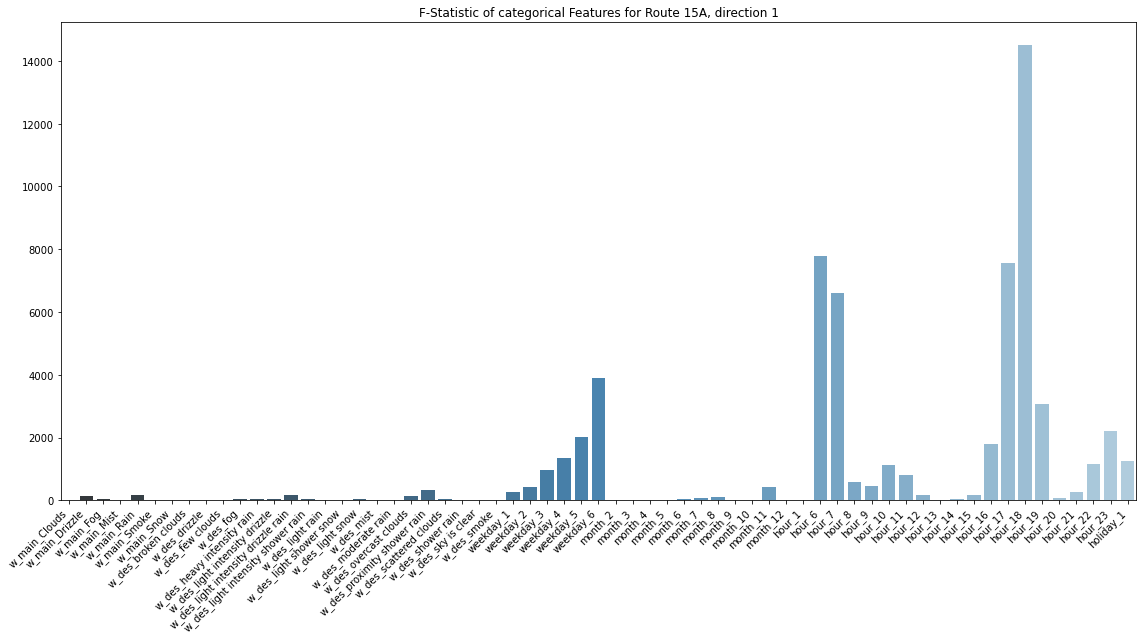

In [69]:
plt.figure(figsize=(16,9))
plt.title("F-Statistic of categorical Features for Route 15A, direction 1")
ax = sns.barplot(x=dummy_columns, y=fs.scores_,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.savefig("test.png")

<div>Both weather features seem to not have a significant influence on the target feature as they dwarf in comparison. as weather is demanded in the project deliverables, we will keep it for now and test models with the detailed description, the low cardinality description, and without weather.</div>
<br>
<div>of the remaining features, month could have low to no influence. we will try different model configurations with and without month. weekday, hour and holiday display a strong relationship with the target variable, be it only for some of their values.</div>

In [70]:
numeric=X_train.columns[(X_train.dtypes=="int64") | (X_train.dtypes=="float64")]

In [71]:
corr=pd.concat([X_train[numeric], y], axis=1).corr()

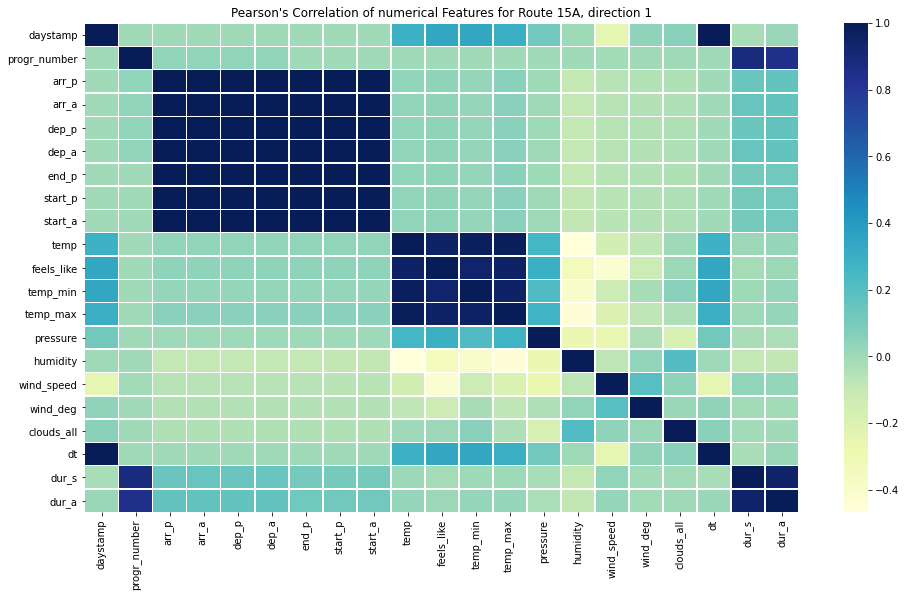

In [72]:
plt.figure(figsize=(16,9))
plt.title("Pearson's Correlation of numerical Features for Route 15A, direction 1")
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidth=.5,cmap="YlGnBu")
plt.savefig("PearsonsCorr")

In [49]:
corr["dur_a"].sort_values()

humidity       -0.084925
pressure       -0.029210
wind_deg       -0.004104
clouds_all     -0.001515
feels_like      0.011756
daystamp        0.015891
dt              0.016202
wind_speed      0.024492
temp_max        0.025732
temp_min        0.026063
temp            0.027585
start_p         0.119037
start_a         0.119315
end_p           0.127070
dep_p           0.160000
arr_p           0.160000
dep_a           0.168425
arr_a           0.168501
progr_number    0.842383
dur_s           0.943613
dur_a           1.000000
Name: dur_a, dtype: float64

In [50]:
high_corr=corr["dur_a"][(corr["dur_a"]>=0.5) | (corr["dur_a"]<=-0.5)]

In [51]:
numeric=high_corr.drop(["dur_a"]).index

In [52]:
numeric

Index(['progr_number', 'dur_s'], dtype='object')

<div>above's heatmap shows that the scheduled duration and progr_number have a very strong correlation with the target value, but there is a large dropoff afterwards. namely, the temperature and other weather features have no meaningful impact on the acutal duration of a trip. due to these findings, no numerical feature but progr_number and dur_s will be considered for modelling.</div>
<br>
<div>furthermore, dur_s and progr_number show a strong correlation. during the modelling, we will examine whether the progr_number can be dropped.</div>

In [53]:
X_numeric=X[numeric]

<h3>Modelling</h3>

In the previous section, we identified the features weather_main, weather_description, month and progr_number as potentially redundant. we will test on a linear regressor with and without these features to find out whether they are beneficial for performance. then, we will test different models that are computationally more expensive and see whether they perform superior. finally, we will choose the best performing model, and - if it is not the linear regressor - see if it performs better with other feature combinations.

<h4>Linear Regression</h4>

In [54]:
X=pd.concat([X[categorical],X[numeric]],axis=1)
y=df_clean["dur_a"]

In [55]:
X.head()

,weather_main,weather_description,weekday,month,hour,holiday,progr_number,dur_s
0,Drizzle,light intensity drizzle rain,6,2,16,0,1,0
1,Drizzle,light intensity drizzle rain,6,2,16,0,2,62
2,Drizzle,light intensity drizzle rain,6,2,16,0,3,96
3,Drizzle,light intensity drizzle rain,6,2,16,0,4,146
4,Drizzle,light intensity drizzle rain,6,2,16,0,5,187


In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

In [57]:
#train with high cardinality weather
X_train_moweather=pd.get_dummies(X_train.drop(["weather_main"],axis=1),drop_first=True)
X_test_moweather=pd.get_dummies(X_test.drop(["weather_main"],axis=1),drop_first=True)

In [60]:
reg = LinearRegression().fit(X_train_moweather, y_train)
reg.score(X_test_moweather, y_test)

0.9006877661542715

In [61]:
#train with low cardinality weather
X_train_moweather=pd.get_dummies(X_train.drop(["weather_description"],axis=1),drop_first=True)
X_test_moweather=pd.get_dummies(X_test.drop(["weather_description"],axis=1),drop_first=True)

In [62]:
reg = LinearRegression().fit(X_train_moweather, y_train)
reg.score(X_test_moweather, y_test)

0.9005391669055989

In [63]:
#train without weather
X_train_moweather=pd.get_dummies(X_train.drop(["weather_main","weather_description"],axis=1),drop_first=True)
X_test_moweather=pd.get_dummies(X_test.drop(["weather_main","weather_description"],axis=1),drop_first=True)

In [64]:
reg = LinearRegression().fit(X_train_moweather, y_train)
reg.score(X_test_moweather, y_test)

0.9004289419570239

The differences between the accuracies are marginal, but as the model with high cardinality weather was performing the best, we will keep it for now.

Next, we will examine whether the model can perform the same without the month feature:

In [65]:
X_train_nomonths=pd.get_dummies(X_train.drop(["month","weather_main"],axis=1),drop_first=True)
X_test_nomonths=pd.get_dummies(X_test.drop(["month","weather_main"],axis=1),drop_first=True)

In [66]:
reg = LinearRegression().fit(X_train_nomonths, y_train)
reg.score(X_test_nomonths, y_test)

0.8995016173919064

The model accuracy decreases slightly, so we will keep the months feature for now.

Next, we will examine whether the model performs at the same level when progr_number is dropped. the suspicion is that dur_s already holds the same information with higher explanatory power as the two features display a high correlation.

In [67]:
X_train_noprogr=pd.get_dummies(X_train.drop(["progr_number","weather_main"],axis=1),drop_first=True)
X_test_noprogr=pd.get_dummies(X_test.drop(["progr_number","weather_main"],axis=1),drop_first=True)

In [68]:
reg = LinearRegression().fit(X_train_noprogr, y_train)
reg.score(X_test_noprogr, y_test)

0.8989947941677487

<div>As the accuracy decreases, we will keep progr_number.</div>
<br>
<div>In summary, we keep the detailed weather and decided to neither drop month nor progr_number.

<h4>Polynomial Regression</h4>

In [70]:
X_large=pd.get_dummies(X.drop(["weather_main"],axis=1),drop_first=True)

In [71]:
X_large.shape

(595111, 58)

In [72]:
X_train,X_test,y_train,y_test=train_test_split(X_large,y,random_state=1)

In [73]:
%%time
#first of, let's model a polyonmial of degree 2:
pol=PolynomialFeatures(2)
X_train_pol=pol.fit_transform(X_train)
X_test_pol=pol.fit_transform(X_test)
reg=LinearRegression()
reg.fit(X_train_pol,y_train)

Wall time: 2min 31s


LinearRegression()

In [74]:
reg.score(X_test_pol,y_test)

0.920499778108856

In [75]:
X_train_pol.shape[1]

1770

We can see that the shape of the columns has dramatically increased. Before doing any more experiments, let's transform a small sample to see how many features we would have for degree 3:

In [78]:
X_sample=X_large.iloc[:2]

In [79]:
pol=PolynomialFeatures(3)
X_sample_pol=pol.fit_transform(X_sample)

In [80]:
X_sample_pol.shape

(2, 35990)

<div>As the feature number is continuing to increase drastically, we will not consider any degree over 2 for modelling.</div>
<br>
<div>For n=2, the running time of > 150s is already fairly slow. Thus, we will look into how well the model performs if we use a smaller feature set that should speed up training:</div>


In [82]:
X_small=pd.get_dummies(X.drop(["weather_main","weather_description","month","progr_number"],axis=1),drop_first=True)

In [83]:
X_train,X_test,y_train,y_test=train_test_split(X_small,y,random_state=1)

In [84]:
%%time
pol=PolynomialFeatures(2)
X_train_pol=pol.fit_transform(X_train)
X_test_pol=pol.fit_transform(X_test)
reg=LinearRegression()
reg.fit(X_train_pol,y_train)

Wall time: 14.7 s


LinearRegression()

In [85]:
reg.score(X_test_pol,y_test)

0.9041880134320467

In [86]:
X_train_pol.shape[1]

406

<h4>XGBoost</h4>

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X_large,y,random_state=1)

In [88]:
%%time
#let's start with a default model
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)

Wall time: 1min 26s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
metrics.r2_score(y_pred=xg_reg.predict(X_test), y_true=y_test)

0.9283155916478713

Default XGBoost model trains faster than Polynomial Regression and is more precise.

In [92]:
%%time
params= {
        'max_depth': [1 , 3, 5],
        'learning_rate': [0.005, 0.01, 0.1, 0.3],
        'n_estimators':[50, 100, 150, 200]

    }
gsearch = GridSearchCV(xgb.XGBRegressor(),param_grid=params,scoring='r2',cv=4)
gsearch.fit(X_large,y)

Wall time: 1h 40min 55s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [98]:
gsearch.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}

In [99]:
gsearch.best_score_

0.9265017424626201

<h4>ANN</h4>

In [94]:
%%time
mlp_reg = MLPRegressor()
mlp_reg.fit(X_train,y_train)

Wall time: 13min 35s


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [96]:
metrics.r2_score(y_pred=mlp_reg.predict(X_test), y_true=y_test)

0.9222134728285898

Perform grid search to find best MLP

In [101]:
mlp_opt = MLPRegressor(max_iter=100,verbose=1)
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    }

In [102]:
%%time
clf=GridSearchCV(mlp_opt, param_grid=params, n_jobs=-1, cv=4)
clf.fit(X_large,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Recurring Value Error despite "clean" training data-> best model must be found manually

<h5>Hidden Layer Sizes</h5>

In [114]:
mlp=MLPRegressor(max_iter=100,hidden_layer_sizes=(50,50,50),verbose=1)

In [115]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 56800.02141109
Iteration 2, loss = 41718.91507974
Iteration 3, loss = 39319.37618955
Iteration 4, loss = 38236.13822660
Iteration 5, loss = 37760.37523336
Iteration 6, loss = 37443.94784356
Iteration 7, loss = 37089.18609023
Iteration 8, loss = 36643.21025819
Iteration 9, loss = 36232.20094652
Iteration 10, loss = 35813.74119247
Iteration 11, loss = 35590.64308945
Iteration 12, loss = 35470.06250656
Iteration 13, loss = 35253.32630842
Iteration 14, loss = 35116.94599072
Iteration 15, loss = 34948.60706427
Iteration 16, loss = 34899.36046837
Iteration 17, loss = 34719.69240022
Iteration 18, loss = 34505.54958285
Iteration 19, loss = 34370.72849901
Iteration 20, loss = 34146.35800243
Iteration 21, loss = 33954.67199307
Iteration 22, loss = 33834.11889318
Iteration 23, loss = 33717.84192607
Iteration 24, loss = 33548.66793551
Iteration 25, loss = 33513.66668510
Iteration 26, loss = 33407.85638359
Iteration 27, loss = 33273.33726117
Iteration 28, loss = 33229.88208550
I

c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=100, verbose=1)

In [116]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.9195611404216483

In [117]:
mlp=MLPRegressor(max_iter=100,hidden_layer_sizes=(50,100,50),verbose=1)

In [118]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 53524.11252602
Iteration 2, loss = 41175.66944980
Iteration 3, loss = 38791.29839296
Iteration 4, loss = 37787.20773283
Iteration 5, loss = 37331.08455037
Iteration 6, loss = 36904.25117097
Iteration 7, loss = 36548.65224376
Iteration 8, loss = 36136.87704158
Iteration 9, loss = 35816.75083359
Iteration 10, loss = 35586.52750331
Iteration 11, loss = 35444.10891378
Iteration 12, loss = 35304.59068247
Iteration 13, loss = 35089.01930046
Iteration 14, loss = 34808.55181125
Iteration 15, loss = 34709.88210207
Iteration 16, loss = 34383.50482864
Iteration 17, loss = 34052.19569119
Iteration 18, loss = 33911.24874363
Iteration 19, loss = 33745.45215144
Iteration 20, loss = 33476.15952911
Iteration 21, loss = 33459.66648723
Iteration 22, loss = 33311.84918036
Iteration 23, loss = 33187.52531924
Iteration 24, loss = 33119.25673062
Iteration 25, loss = 32937.61524930
Iteration 26, loss = 32873.00363462
Iteration 27, loss = 32772.79182337
Iteration 28, loss = 32678.00376369
I

c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(50, 100, 50), max_iter=100, verbose=1)

In [119]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.9276899430622116

more complex architectures do not improve performance in this instance

<h5>Acitvation Function</h5>

In [120]:
mlp=MLPRegressor(max_iter=100,activation="logistic",verbose=1)

In [121]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 1467294.55115756
Iteration 2, loss = 1267021.39182376
Iteration 3, loss = 1085992.57645684
Iteration 4, loss = 923696.82325730
Iteration 5, loss = 778783.38869917
Iteration 6, loss = 650652.27674470
Iteration 7, loss = 538852.93177326
Iteration 8, loss = 442381.86054174
Iteration 9, loss = 360392.51135612
Iteration 10, loss = 291662.78183795
Iteration 11, loss = 234820.22636324
Iteration 12, loss = 188513.21450335
Iteration 13, loss = 151313.40233913
Iteration 14, loss = 122029.16128000
Iteration 15, loss = 99334.60172498
Iteration 16, loss = 82113.01444096
Iteration 17, loss = 69402.50322874
Iteration 18, loss = 60328.06320117
Iteration 19, loss = 54592.40487785
Iteration 20, loss = 50059.38749943
Iteration 21, loss = 47266.37652086
Iteration 22, loss = 45632.31029617
Iteration 23, loss = 44621.04094731
Iteration 24, loss = 43100.06797645
Iteration 25, loss = 41352.45964954
Iteration 26, loss = 40426.66908289
Iteration 27, loss = 39313.24311467
Iteration 28, loss =

MLPRegressor(activation='logistic', max_iter=100, verbose=1)

In [122]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.9097241901694323

In [123]:
mlp=MLPRegressor(max_iter=100,activation="tanh",verbose=1)

In [124]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 1410508.47262987
Iteration 2, loss = 1122864.40081186
Iteration 3, loss = 880531.43024504
Iteration 4, loss = 677966.96113479
Iteration 5, loss = 512451.17385270
Iteration 6, loss = 380648.75108694
Iteration 7, loss = 279003.33755547
Iteration 8, loss = 202837.88425566
Iteration 9, loss = 147594.78281054
Iteration 10, loss = 108906.30436399
Iteration 11, loss = 82810.39632916
Iteration 12, loss = 65923.29440475
Iteration 13, loss = 58447.72114291
Iteration 14, loss = 55576.39779883
Iteration 15, loss = 51236.19961843
Iteration 16, loss = 48625.88970508
Iteration 17, loss = 48568.01495476
Iteration 18, loss = 50180.29898499
Iteration 19, loss = 46034.98555625
Iteration 20, loss = 46127.23437562
Iteration 21, loss = 49482.09996312
Iteration 22, loss = 47440.58046931
Iteration 23, loss = 45249.59383296
Iteration 24, loss = 45147.46404231
Iteration 25, loss = 46197.66646470
Iteration 26, loss = 45233.68376777
Iteration 27, loss = 44129.58349342
Iteration 28, loss = 4388

MLPRegressor(activation='tanh', max_iter=100, verbose=1)

In [125]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.8914463356305302

Using the logistic sigmoid or tangens hyperbole activation does not improve the results (due to early termination as stop condition has been met)

<h5>Solvers</h5>

In [126]:
mlp=MLPRegressor(max_iter=100,solver='sgd',verbose=1)

In [127]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 13574404839032264096168051616053581054950206361296279961600.00000000
Iteration 2, loss = 13682929883680778965749327647439772319258038141198431944704.00000000
Iteration 3, loss = 13682624415153444103233063799788005298730109325117633855488.00000000
Iteration 4, loss = 13682318953445571193887771488357938631316254377848493572096.00000000
Iteration 5, loss = 13682013498557098910664154753935933093791223516396869648384.00000000
Iteration 6, loss = 13681708050487812608889677739274251404866642500283267022848.00000000
Iteration 7, loss = 13681402609237581271686299076961937042197659520383838060544.00000000
Iteration 8, loss = 13681097174806265519396527950604355407545070524439170383872.00000000
Iteration 9, loss = 13680791747193801237377918584659974585718841648409934299136.00000000
Iteration 10, loss = 13680486326399867852418242101421135000768803572099481337856.00000000
Iteration 11, loss = 13680180912424434700992850521281017041082331404010740776960.00000000
Iteration 12, loss 

MLPRegressor(max_iter=100, solver='sgd', verbose=1)

In [128]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

-3.363999863115197e-07

Stochastic Gradient Descent does not produce sensible results.

In [129]:
mlp=MLPRegressor(max_iter=100,solver='lbfgs',verbose=1)

In [130]:
%%time
mlp.fit(X_train,y_train)

Wall time: 5min 11s


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(max_iter=100, solver='lbfgs', verbose=1)

In [131]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.8951197930001313

In [134]:
mlp=MLPRegressor(max_iter=100,alpha=0.05,verbose=1)

In [135]:
%%time
mlp.fit(X_train,y_train)

Iteration 1, loss = 65230.95439351
Iteration 2, loss = 41639.88970481
Iteration 3, loss = 40221.65008547
Iteration 4, loss = 39138.84540678
Iteration 5, loss = 38425.85433635
Iteration 6, loss = 37991.68701840
Iteration 7, loss = 37613.50197837
Iteration 8, loss = 37392.54066368
Iteration 9, loss = 37051.64050603
Iteration 10, loss = 36908.09802641
Iteration 11, loss = 36637.40469403
Iteration 12, loss = 36492.77099198
Iteration 13, loss = 36128.82088082
Iteration 14, loss = 35908.33883081
Iteration 15, loss = 35790.17394602
Iteration 16, loss = 35488.88793325
Iteration 17, loss = 35325.78528558
Iteration 18, loss = 35210.56886230
Iteration 19, loss = 35043.77386439
Iteration 20, loss = 34912.89557860
Iteration 21, loss = 34815.44516199
Iteration 22, loss = 34732.41441353
Iteration 23, loss = 34566.15374373
Iteration 24, loss = 34494.26281133
Iteration 25, loss = 34375.80628196
Iteration 26, loss = 34293.47038199
Iteration 27, loss = 34365.52443873
Iteration 28, loss = 34143.89630609
I

c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.05, max_iter=100, verbose=1)

In [136]:
metrics.r2_score(y_pred=mlp.predict(X_test), y_true=y_test)

0.9203682287491218

<h4>Support Vector Regression</h4>

According to the documentation, the standard support vector regression is not fit for sample sizes over a few 10Ks due to a quadratic fit time complexity. Instead, we will test the recommended LinearSVR and SGDRegressor

In [140]:
regr = make_pipeline(StandardScaler(),LinearSVR(tol=1e-5))

In [141]:
%%time
regr.fit(X_train, y_train)

Wall time: 51.7 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(tol=1e-05))])

In [142]:
metrics.r2_score(y_pred=regr.predict(X_test), y_true=y_test)

0.8982756792828285

In [143]:
reg = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))

In [144]:
%%time
regr.fit(X_train,y_train)

Wall time: 49.9 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(tol=1e-05))])

In [145]:
metrics.r2_score(y_pred=regr.predict(X_test), y_true=y_test)

0.8982783255725295

<h4>Random Forest Regression</h4>

In [148]:
regr = RandomForestRegressor()

In [149]:
%%time
regr.fit(X_train, y_train)

Wall time: 0 ns


RandomForestRegressor()

In [150]:
metrics.r2_score(y_pred=regr.predict(X_test), y_true=y_test)

0.915504879988743

<h4>LSTM</h4>
<br>
<div>LSTMs are recurrent neural network that learn from a temporal relationship in the data. Successfully training and implementing a LSTM requires that there is a trend over time in a temporal relationship and that the value of earlier time periods can be used for later time periods in practice. The following temporal relationships exist in the data.</div>
<br>
<ul>
    <li>month: This is not fit for LSTM as there is no clear trend in the months</li>
    <li>hour: This could be a promising candidate for LSTM as there is a clear bimodal trend in the distribution. However, the backend of our web application currently does not allow us to capture the all travelling times over the duration of a day, so this approach cannot be employed in practice at this time</li>
    <li>dur_a over progression of trip (not depicted above): Assuming a trip from x to y, it can be logically reasoned that there must be a relationship between dur_a at stop x and dur_a at stop y. However, we do not have access to dur_a in real time in our backend, so a model trained on this relationship is not practical at this time.</li>

<h3>Benchmark</h3>
<br>
<div>In order to evaluate the model performances, they needs to be compared to an alternative. As we do not have access to historic route predictions by google, which thanks to the advent of smart phones and mobile internet is certainly is the most prevalent alternative, we will resort to the 2nd best alternative, which is the timetable information

In [146]:
metrics.r2_score(y_pred=X_test.dur_s, y_true=y_test)

0.8556210188476404

In [153]:
X_test.shape

(148778, 58)

<h3>Validation of best performing Models</h3>
<br>
<div>Will be done in modelling_pipeline_test.ipynb.</div>